In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold


In [2]:
!pip install tensorflow==1.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.1 MB/s eta 0:00:00:00:01
^C
ERROR: Operation cancelled by user


In [3]:
import tensorflow as tf
tf.__version__

'2.6.4'

In [4]:
!pip install keras==2.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.9/334.9 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires keras<2.7,>=2.6.0, but you have keras 2.1.5 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflo

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

In [7]:
DATA_DIR = Path('/kaggle/input')
ROOT_DIR = Path('/kaggle/working')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [8]:
# !git clone https://github.com/leekunhee/Mask_RCNN.git
# os.chdir('Mask_RCNN')
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 62.19 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [9]:
sys.path.append("/kaggle/working/Mask_RCNN/")
# import mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [10]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [11]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [12]:
#make a json file with category: article type and supercategory: subCategory
style = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines="skip")
df_cat_sub_cat = pd.DataFrame(columns=['id', 'category', 'subcategory'])

cat = list(set(style['articleType']))
ids = [i for i in range(len(cat))]
sup_cat = []
for i in cat:
    sup_cat.append(set(style[style['articleType'] == i].subCategory))


In [13]:
d = {}
for i in range(len(ids)):
    d[i] =  {"id": ids[i], "name": cat[i], "supercategory": sup_cat[i]}

In [14]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

In [15]:
import json
with open("label_descriptions.json", "w") as outfile:
    json.dump(d, outfile, cls=SetEncoder)

In [16]:
with open("label_descriptions.json") as f:
    label_descriptions = json.load(f)


In [17]:
label_names = cat

In [18]:
def resize_image(image_path):
    img_path = '/kaggle' + image_path[2:]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    img = cv2.resize(img, (224, 224),  interpolation=cv2.INTER_AREA)  
    return img

In [19]:
features = pd.read_csv("/kaggle/input/resnet-emb/emb_matrix.csv")
filename_ids = pd.read_csv("/kaggle/input/filenames-ids/file_name_id.csv")
emb_with_ids = pd.concat([features, filename_ids], axis = 1, ignore_index=False)
emb_with_ids.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,filename,id
0,11.467101,24.375347,2.394572,5.675438,10.293070,4.396041,15.002939,7.942683,3.122722,9.764480,...,10.167510,12.207253,11.108115,3.917942,11.812906,8.912256,7.527889,21.203213,../input/fashion-product-images-dataset/fashio...,15970
1,11.360403,28.873011,6.209032,4.508435,10.942026,9.140931,19.895555,11.455869,3.406259,4.944487,...,11.673160,5.906898,6.890153,3.207030,8.099847,7.459054,6.093646,26.040031,../input/fashion-product-images-dataset/fashio...,39386
2,6.315001,18.561722,1.157191,1.423485,21.873127,4.470167,15.399438,16.044966,6.415497,6.616863,...,7.018058,7.973488,8.528345,4.429887,14.573654,5.060492,13.813715,11.160487,../input/fashion-product-images-dataset/fashio...,59263
3,15.669891,18.728531,7.941226,6.822183,11.345028,7.277330,17.457182,10.186830,2.913542,5.126184,...,7.440072,5.530585,15.117517,11.030376,9.127235,15.141878,7.827703,9.321061,../input/fashion-product-images-dataset/fashio...,21379
4,14.826392,15.778180,5.702676,7.882212,15.539780,6.508905,19.649069,15.052256,3.271335,7.763330,...,10.826401,9.204471,20.001060,2.589969,5.004478,14.578427,9.850271,23.341358,../input/fashion-product-images-dataset/fashio...,53759


In [26]:
dataset = pd.read_csv('/kaggle/input/labelled-data/labelled_data.csv')


In [27]:
dataset.articleType[32006]

'Tops'

In [28]:
# def get_img_tensor()
import tensorflow as tf
def img_tensor(img_path):
# load image via tf.io
#     img = tf.io.read_file("/kaggle/input/img-query/img.jpeg")
    img_path = '/kaggle' + img_path[2:]
    img = tf.io.read_file(img_path)
    # convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
    # set the dtypes to align with pytorch for comparison since it will use uint8 by default
    tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32, expand_animations = False)
    # (384, 470, 3)

    # resize tensor to 224 x 224
    tensor = tf.image.resize(tensor, [224, 224])
    # (224, 224, 3)

    # add another dimension at the front to get NHWC shape
    input_tensor = tf.expand_dims(tensor, axis=0)

    return input_tensor

In [29]:

from PIL import Image
initializer = tf.keras.initializers.Zeros()
image = initializer(shape=(1, 224, 224, 3))
img_data = np.random.random(size=(224, 224, 3))
img = tf.keras.utils.array_to_img(img_data)
colors = tf.keras.preprocessing.image.img_to_array(img)

for i in range(1):
    image_id = int(random.choice(dataset.id))
    print(int(image_id))
    if image_id in dataset.id:

    image = img_tensor(dataset.filename[image_id])
    # print(image.shape)
    image1 = resize_image(str(dataset.filename[image_id])

#     print(type(image))
    mask = visualize.apply_mask(np.array(image), 2, colors, 1)


    visualize.display_top_masks(image1, mask[image_id], image_id, dataset.articleType, limit=1)

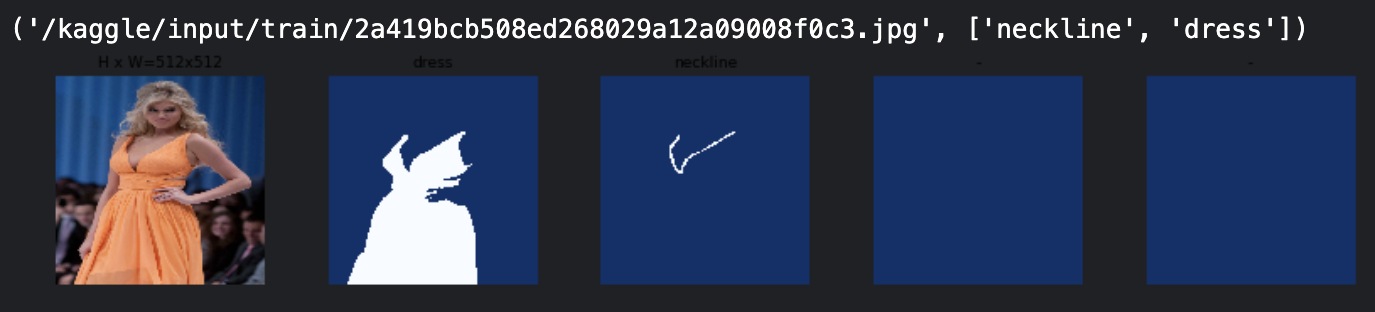

In [ ]:
from sklearn.model_selection import train_test_split

rng = np.random.RandomState()

train = dataset.sample(frac=0.7, random_state=rng)
test = dataset.loc[~dataset.index.isin(train.index)]

In [ ]:
LR = 1e-4
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# !pip install tensorflow==2.3.1

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True)

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [ ]:
model.train(train, test,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()


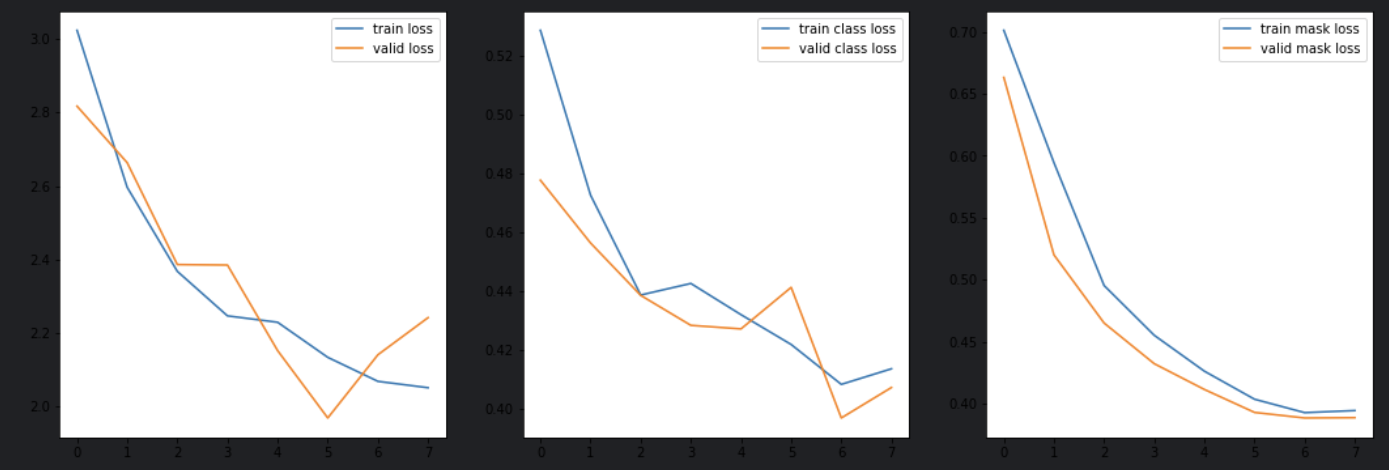

In [ ]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [ ]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [ ]:
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

In [ ]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(24, 24))

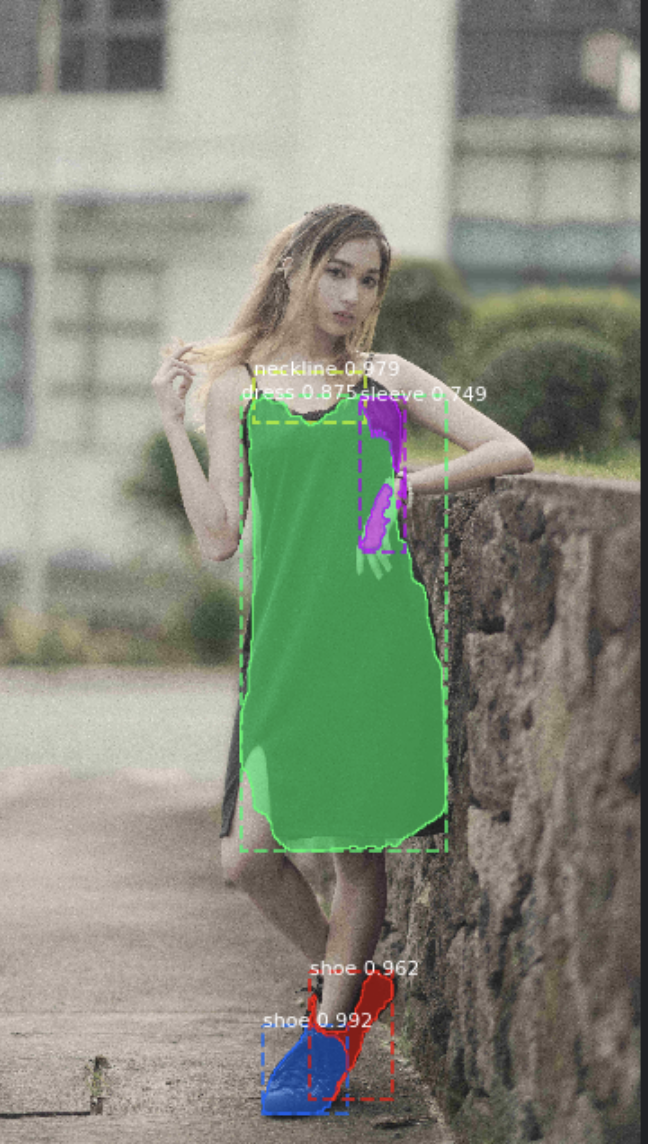

In [ ]:
i_m = cv2.imread(str(img_paths[0]))
plt.imshow(i_m)

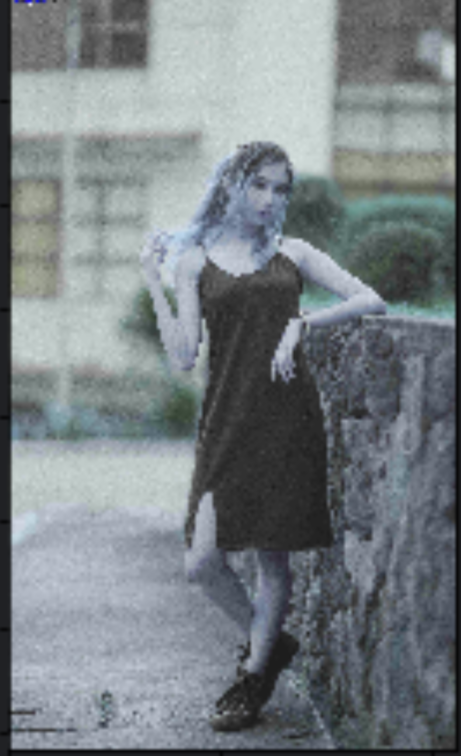

In [ ]:
one = rois[0]
print(one[0], one[1], one[2], one[3])
cropped = i_m[one[0]:one[2], one[1]:one[3]]

plt.imshow(cropped)

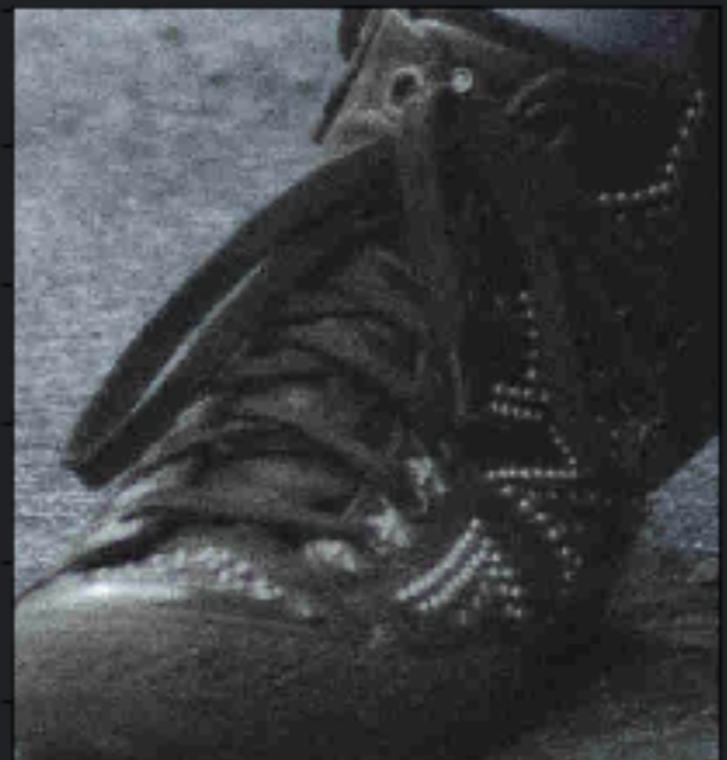

In [ ]:
one = rois[1]
print(one[0], one[1], one[2], one[3])
cropped = i_m[one[0]:one[2], one[1]:one[3]]

plt.imshow(cropped)

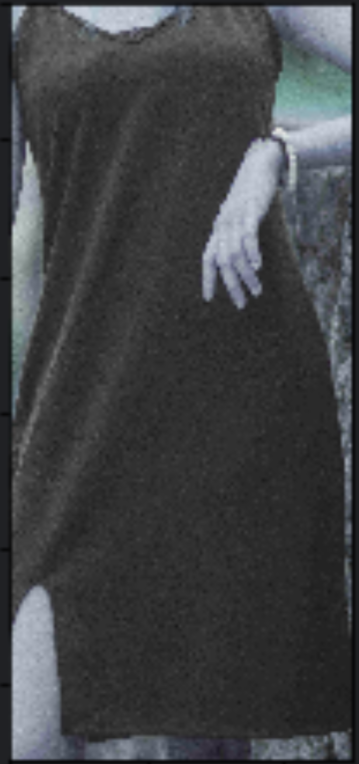

In [ ]:
one = rois[2]
print(one[0], one[1], one[2], one[3])
cropped = i_m[one[0]:one[2], one[1]:one[3]]

plt.imshow(cropped)

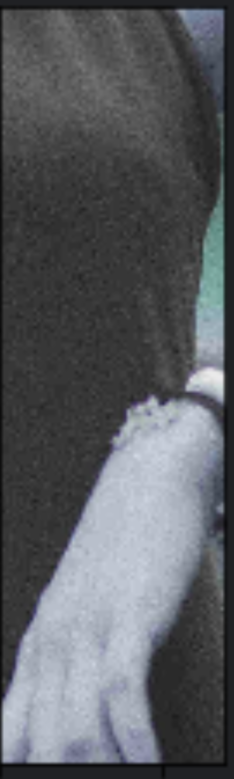